In [1]:
%load_ext autoreload
%autoreload 2
import sys
from numba import njit
from glob import glob
from natsort import natsorted
from joblib import Parallel, delayed
sys.path.insert(0, "../../") 
import tifffile
from helpers import *
import nd2
from PIL import Image
import global_params
from tqdm.auto import tqdm
from skimage.segmentation import clear_border

sys.path.insert(0, "/home/gh464/Documents/GitHub/SyMBac/") 
from SyMBac.drawing import  get_crop_bounds_2D

In [4]:
def load_img_mask_pair(img_dir, mask_dir, normalise = False):
    suffix = img_dir.split(".")[-1]
    if "png" in suffix:
        img = np.array(Image.open(img_dir))
    elif "tif" in suffix:
        img = tifffile.imread(img_dir).sum(axis=0)
    if normalise:
        img = rescale_intensity(img, out_range=(0,1))
    mask = np.array(Image.open(mask_dir)) #Masks are always PNG
    return img, mask

@njit
def get_intensities(img, mask, mask_labels, img_2 = None):
    """
    Returns intensities of objects in the order provided by mask_labels
    """
    total_intensities = np.zeros(len(mask_labels))
    for l, mask_label in enumerate(mask_labels):
        idxs = np.where(mask == mask_label)
        if len(idxs[0]) > 100:
            pixel_intensities = np.zeros(len(idxs[0]))
            for k, (i, j) in enumerate(zip(idxs[0], idxs[1])):
                pixel_intensities[k] = img[i,j]
            total_intensity = np.sum(pixel_intensities)
            total_intensities[l] = total_intensity
    total_intensities_2 = np.zeros(len(mask_labels))

    if img_2 is not None:
        total_intensities_2 = np.zeros(len(mask_labels))
        for l, mask_label in enumerate(mask_labels):
            idxs = np.where(mask == mask_label)
            if len(idxs[0]) > 100:
                pixel_intensities = np.zeros(len(idxs[0]))
                for k, (i, j) in enumerate(zip(idxs[0], idxs[1])):
                    pixel_intensities[k] = img_2[i,j]
                total_intensity = np.sum(pixel_intensities)
                total_intensities_2[l] = total_intensity
    return total_intensities, total_intensities_2

def get_colony_diameter(mask):
    colony_regionprop = regionprops((mask > 0)*1)[0]
    return colony_regionprop.feret_diameter_max


def get_colony_centroid(mask):
    colony_regionprop = regionprops((mask > 0)*1)[0]
    #colony_centroid = colony_regionprop.centroid
    return colony_regionprop.centroid

def get_cell_pos(mask, mask_labels):
    cell_ys = np.zeros(len(mask_labels))
    cell_xs = np.zeros(len(mask_labels))
    for i, mask_label in enumerate(mask_labels):
        single_cell = (mask == mask_label) * 1
        cell_ys[i], cell_xs[i] = regionprops(single_cell)[0].centroid
    return cell_ys, cell_xs
#get_colony_size(mask)

def get_cell_n_neighbours(mask,mask_labels):
    radius = 5
    dilated = dilation(mask, skimage.morphology.disk(radius))
    rag = graph.RAG(dilated)
    rag.remove_node(0)

    n_neighbours = []
    for mask_label in mask_labels:
        n_neighbours.append(len(list(rag.neighbors(mask_label))))
    return n_neighbours

def get_cell_areas(mask, mask_labels):
    areas = np.zeros(len(mask_labels))
    for i, mask_label in enumerate(mask_labels):
        areas[i] = np.sum(mask == mask_label)
    return areas

In [16]:
data_dirs = glob("../real_data/SB5_SB6_SB7_SB8_MM/*c4*")
from natsort import natsorted
data_dirs = natsorted(data_dirs)
mask_dirs = natsorted(glob("../real_data/SB5_MM_segmented/*.png"))

In [17]:
def process_MM_frame(i):
    raw_img = synth_img = tifffile.imread(data_dirs[i])
    mask = np.array(Image.open(mask_dirs[i]))
    mask_labels = np.unique(mask)[1:]

    data = pd.DataFrame()

    data["Label"] = mask_labels
    data["True intensity"], data["Observed intensity"] = get_intensities(raw_img, mask, mask_labels, synth_img)

    #data["Colony ID"] = i
    data["Area"] = get_cell_areas(mask, mask_labels)
    return data

In [18]:
datas = Parallel(n_jobs=-1)(delayed(process_MM_frame)(i) for i in (range(len(mask_dirs))))

In [19]:
data = pd.concat(datas)

In [20]:
data["Mean true intensity"] = data["True intensity"] / data["Area"]

In [21]:
data = data[~(data["Mean true intensity"] == 0)]
#data = data.query(" 100 < `Mean true intensity` < 550")
#data = data.query("`Area` < 400")
#data = data.query("`Area` > 250")

In [22]:
data["Area"].max()

4264.0

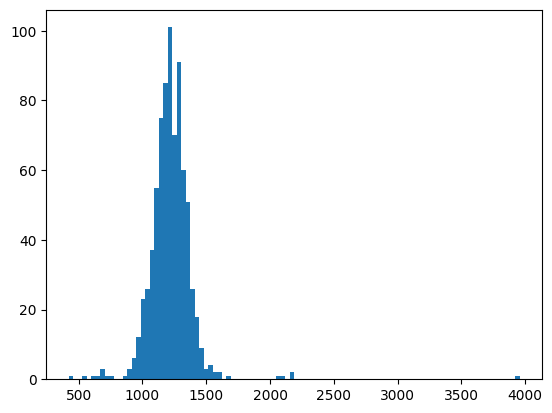

In [23]:
plt.hist(data["Mean true intensity"],bins=100)
plt.show()

In [24]:
data["Mean true intensity"].std() / data["Mean true intensity"].mean()

0.14700007911325566

In [25]:
np.log(data["Mean true intensity"]).var() / np.log(data["Mean true intensity"]).mean() * 100

0.2601220331946751

In [26]:
0.1/11 * 100

0.9090909090909092

Double check manually

In [27]:
i = 0


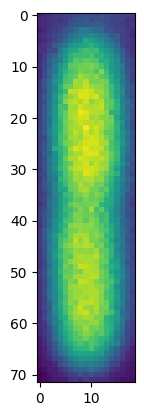

In [118]:
(r1, r2), (c1, c2) = get_crop_bounds_2D(single_cell, tol = 0)
plt.imshow(raw_img[r1:r2,c1:c2])

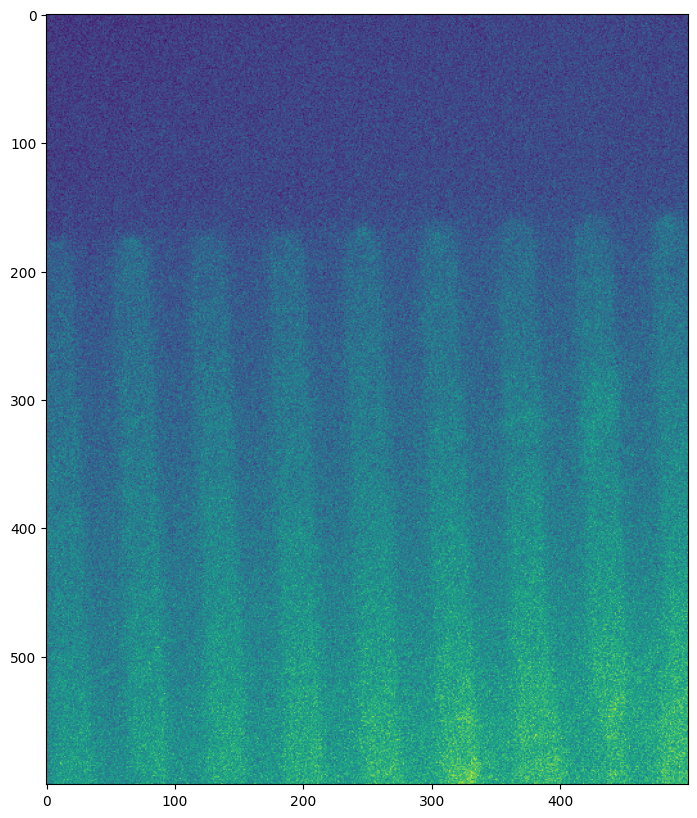

In [33]:
plt.figure(figsize=(10,10))
raw_img = synth_img = tifffile.imread(data_dirs[9])
plt.imshow(raw_img[400:1000,0:500])

In [34]:
raw_img[400:1000,0:500].mean()

320.22802

In [60]:
intensities = []
for i in tqdm(range(len(data_dirs))):
    raw_img = synth_img = tifffile.imread(data_dirs[i]) 
    mask = clear_border(np.array(Image.open(mask_dirs[i])))
    mask_labels = np.unique(mask)[1:]
    for label in mask_labels:
        single_cell = (mask == label)
        single_cell_FL = single_cell * raw_img
        area = np.sum(single_cell)
        total_intensity = np.sum(single_cell_FL)
        mean_intensity = total_intensity/area - 320
        intensities.append(mean_intensity)
        
print(np.std(intensities))
print(np.mean(intensities))

  0%|          | 0/51 [00:00<?, ?it/s]

186.39043910427037
898.4984773686716


In [61]:
(np.std(intensities) / np.mean(intensities))

0.20744658315964035

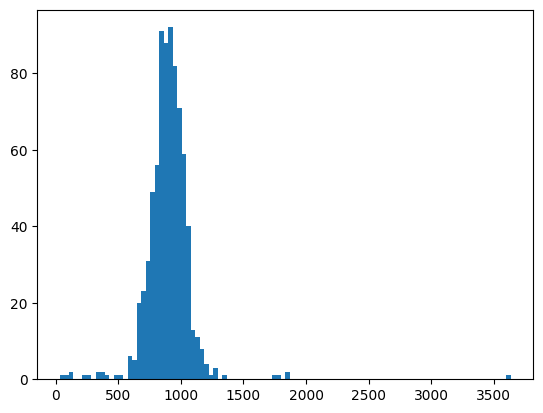

In [62]:
plt.hist(intensities, bins = 100)
plt.show()

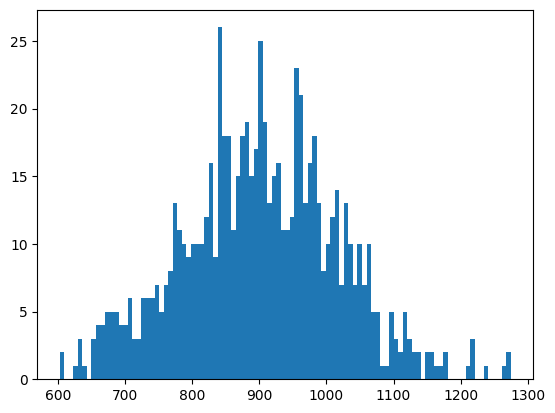

In [66]:
intensities_cropped = [x for x in intensities if 1300 > x > 600 ]
plt.hist(intensities_cropped, bins = 100)
plt.show()

In [67]:
(np.std(intensities_cropped) / np.mean(intensities_cropped))

0.12973998052957444

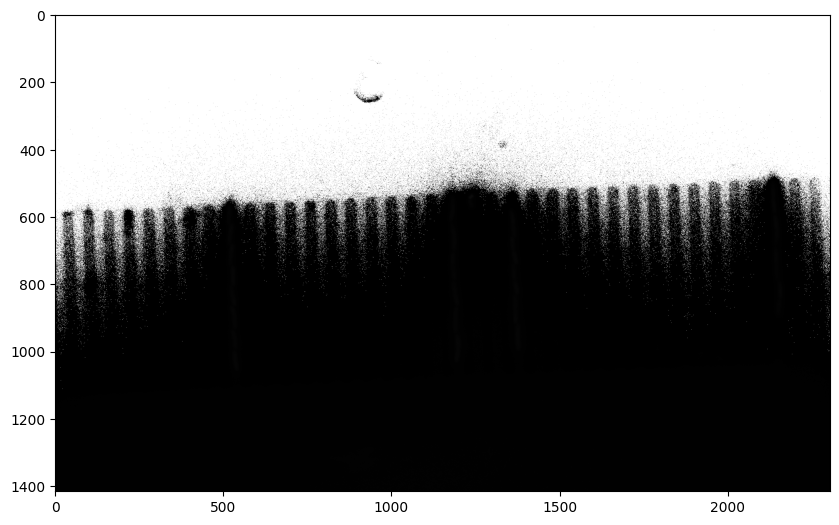

In [57]:
plt.figure(figsize=(10,10))
plt.imshow(tifffile.imread(data_dirs[i]) - 320, cmap="Greys_r")

In [48]:
intensities = []
for i in tqdm(range(len(data_dirs))):
    raw_img = synth_img = tifffile.imread(data_dirs[i]) 
    
    mask = clear_border(np.array(Image.open(mask_dirs[i])))
    mask_labels = np.unique(mask)[1:]
    for label in mask_labels:
        single_cell = (mask == label)
        single_cell_FL = single_cell * raw_img
        area = np.sum(single_cell)
        total_intensity = np.sum(single_cell_FL)
        mean_intensity = total_intensity/area - 320
        intensities.append(mean_intensity)
        
print(np.std(intensities))
print(np.mean(intensities))

  0%|          | 0/51 [00:00<?, ?it/s]

186.39043910427037
898.4984773686716


In [15]:
(np.std(intensities) / np.mean(intensities)) ## YFP

0.1537425742846739

In [41]:
(np.std(intensities) / np.mean(intensities)) ## CFP 

0.5797333212059431

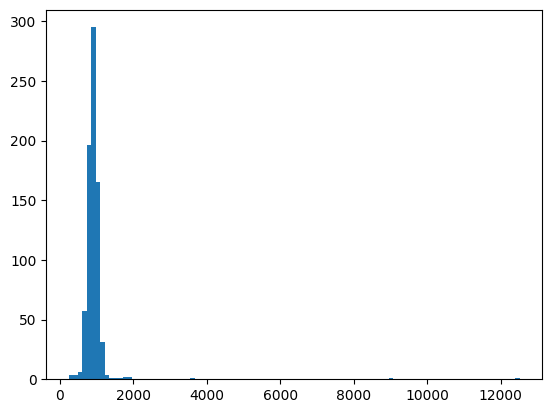

In [43]:
plt.hist(intensities, bins = 100)
plt.show()